# Aufgabe 3
## a) TSLA Stock

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 5.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.60-py2.py3-none-any.whl size=23819 sha256=d7ba3c07e688c1ef8e6592605977a92f4b6259d72b685474598c83e981ea9793
  Stored in directory: /root/.cache/pip/wheels/f0/be/a4/846f02c5985562250917b0ab7b33fff737c8e6e8cd5209aa3b
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
data = yf.download('TSLA', start='2020-01-01', end='2021-05-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

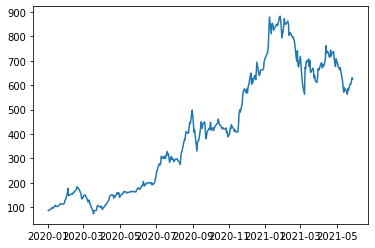

In [ ]:
plt.plot(data["Close"])
plt.show()

In [ ]:
data = data["Close"]

## b) Preprocessing + Train/Test Split

In [ ]:
# Normalize between 0 and 1
from sklearn import preprocessing
data = preprocessing.normalize([data])[0]

In [ ]:
print(data[0:5])

[0.00951441 0.00979635 0.00998498 0.0103724  0.01088277]


In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [ ]:
from sklearn.model_selection import train_test_split

def create_test_train_dataset(dataset, look_back=1):
  X, y = create_dataset(dataset, look_back)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  return X_train, X_test, y_train, y_test

## c) LTSM Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

np.random.seed(7)

In [ ]:
# Keras RMSE wouldnt work, so we use a self defined function:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Create Models for different look_back values
ltsm = {}
history = {}
for i in range(1,21):
  X_train, X_test, y_train, y_test = create_test_train_dataset(data, look_back = i)
  ltsm[i] = Sequential()
  ltsm[i].add(LSTM(4, input_shape=(1, i)))
  ltsm[i].add(Dense(1))
  ltsm[i].compile(loss=root_mean_squared_error, optimizer='adam')
  ltsm[i].summary()
  history[i] = ltsm[i].fit(X_train, y_train, epochs=200, batch_size=1, verbose=2, validation_data=(X_test,y_test))

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 173/200
276/276 - 0s - loss: 0.0021 - val_loss: 0.0020
Epoch 174/200
276/276 - 0s - loss: 0.0024 - val_loss: 0.0027
Epoch 175/200
276/276 - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 176/200
276/276 - 0s - loss: 0.0021 - val_loss: 0.0034
Epoch 177/200
276/276 - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 178/200
276/276 - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 179/200
276/276 - 0s - loss: 0.0022 - val_loss: 0.0027
Epoch 180/200
276/276 - 0s - loss: 0.0020 - val_loss: 0.0032
Epoch 181/200
276/276 - 0s - loss: 0.0020 - val_loss: 0.0019
Epoch 182/200
276/276 - 0s - loss: 0.0020 - val_loss: 0.0021
Epoch 183/200
276/276 - 0s - loss: 0.0021 - val_loss: 0.0030
Epoch 184/200
276/276 - 0s - loss: 0.0021 - val_loss: 0.0019
Epoch 185/200
276/276 - 0s - loss: 0.0020 - val_loss: 0.0026
Epoch 186/200
276/276 - 0s - loss: 0.0021 - val_loss: 0.0020
Epoch 187/200
276/276 - 0s - loss: 0.0020 - val_loss: 0.0022
Epoch 188/200
276/

## e) Loss (RMSE)

Zu sehen ist für alle 20 trainierten Modelle der RMSE Loss für Trainings- und Testdatensatz.

In diesen Plots ist sichtbar, dass der Fehler im Testdatensatz über die Epochen eine deutlich höhere Varianz besitzt, als der Trainingsdatensatz, und dass diese Varianz mit zunehmendem "look-back" ebenfalls zunimmt.

Dies kann auf gradient exploding zurückzuführen sein.

Mit zunehmender Anzahl von Epochen, wird der Unterschied zwischen Trainings- und Testdaten auch größer, was auf ein Overfitting des Neuronalen Netzes auf die Trainingsdaten zurückzuführen ist.

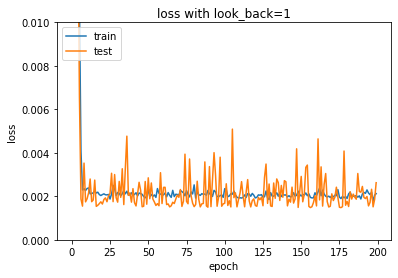

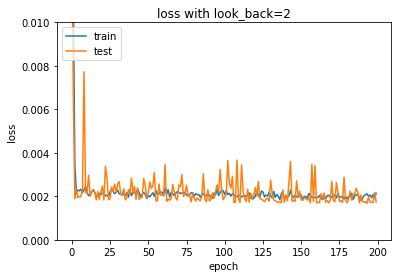

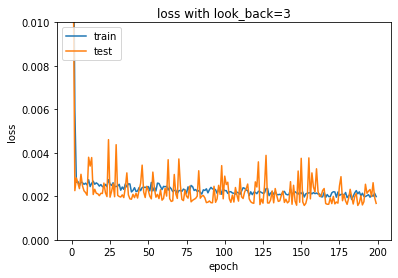

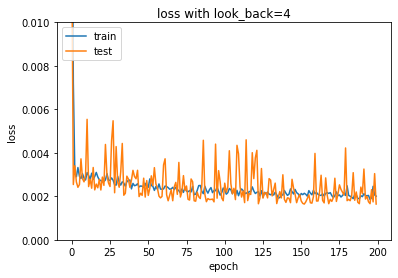

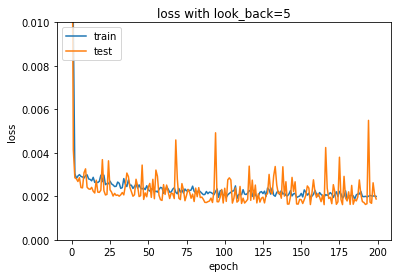

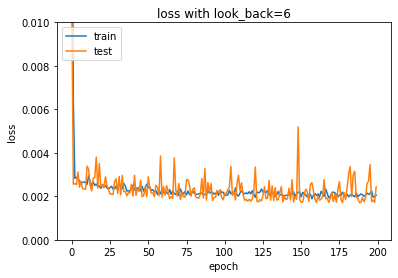

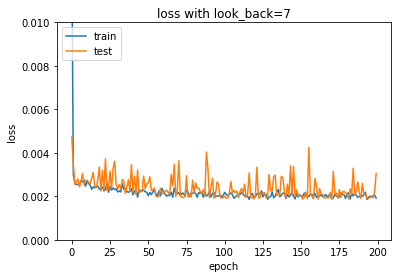

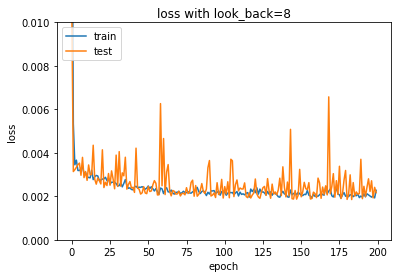

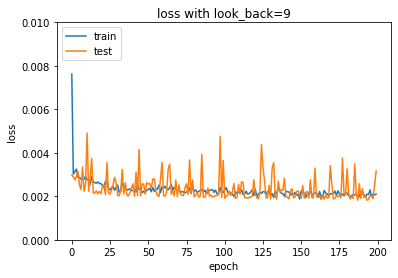

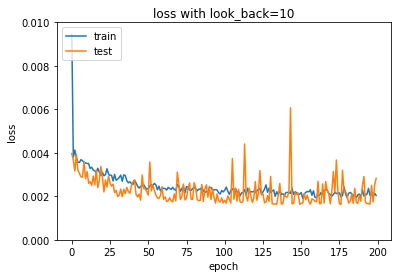

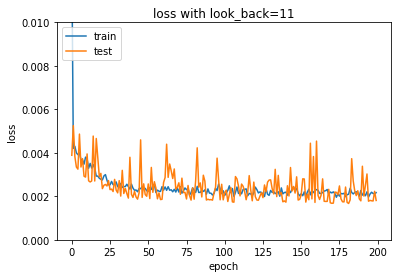

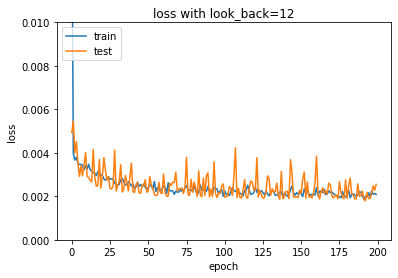

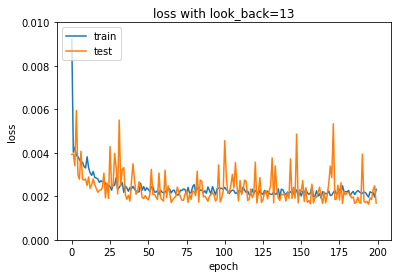

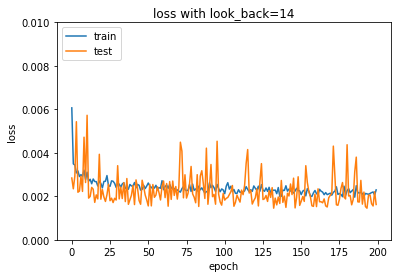

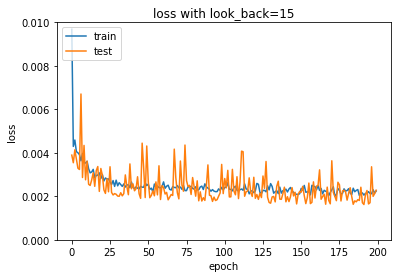

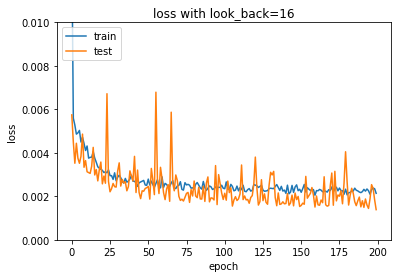

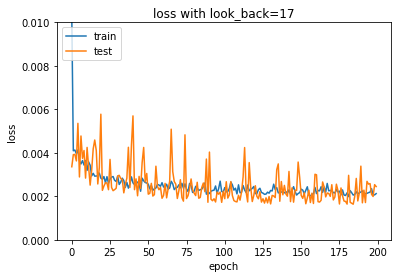

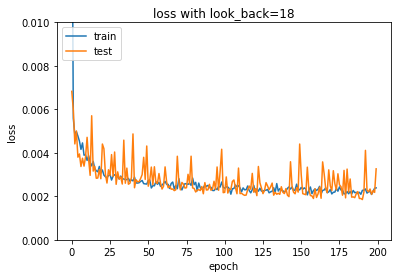

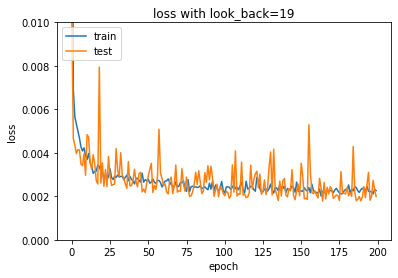

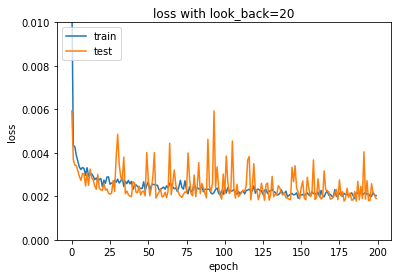

In [ ]:
for x in history:
  plt.plot(history[x].history['loss'])
  plt.plot(history[x].history['val_loss'])
  plt.ylim(0,0.01)
  plt.title('loss with look_back={}'.format(x))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## f) Complexity Dimension

Als Komplexität wurde die Anzahl an historischen Datenpunkten verwendet. (die letzten $n$ Datenpunkte vor dem aktuellen Datenpunkt)
Hierbei wurden zwischen 1 und 20 historische Datenpunkte verwendet.

Zu sehen ist ein Plot des Mittelwerts, Minimalwerts, Maximalwerts, sowie des Wertes der letzten Epoche (200)

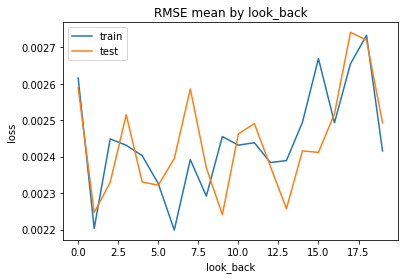

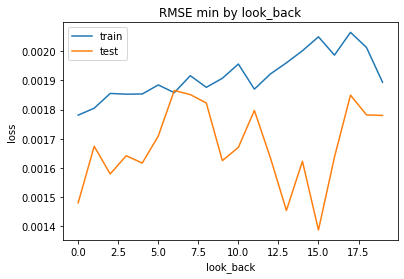

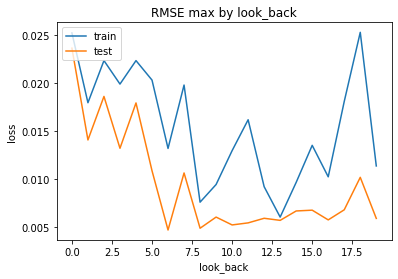

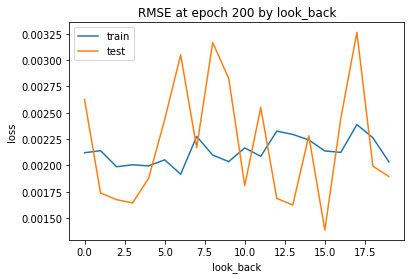

In [ ]:
plt.plot([np.array(history[x].history['loss']).mean() for x in history])
plt.plot([np.array(history[x].history['val_loss']).mean() for x in history])
plt.title('RMSE mean by look_back')
plt.ylabel('loss')
plt.xlabel('look_back')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot([np.array(history[x].history['loss']).min() for x in history])
plt.plot([np.array(history[x].history['val_loss']).min() for x in history])
plt.title('RMSE min by look_back')
plt.ylabel('loss')
plt.xlabel('look_back')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot([np.array(history[x].history['loss']).max() for x in history])
plt.plot([np.array(history[x].history['val_loss']).max() for x in history])
plt.title('RMSE max by look_back')
plt.ylabel('loss')
plt.xlabel('look_back')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot([history[x].history['loss'][-1] for x in history])
plt.plot([history[x].history['val_loss'][-1] for x in history])
plt.title('RMSE at epoch 200 by look_back')
plt.ylabel('loss')
plt.xlabel('look_back')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## g)

RNNs bieten sich für Zeitreihen an, da die Datenpunkte voneinander abhängig sind. Bei klassischen Klassifikations- oder Regressionsproblemen wird jedes Datum unabhängig voneinander betrachtet. Bei Zeitreihen ist die Vergangenheit jedoch wichtig.

Im Gegensatz zu Feed-Forward Netzen besitzen RNNs Verbindungen, die im Netz auch wieder zurück gehen. Dies wird auch Rückkopplung genannt.

Da RNNs auch vergangene Daten verarbeitet, und nicht nur ein einzelnes Datum, bietet sich ein RNN sehr gut für Zeitreihen, oder natürliche Sprache an.

## h)
Als exploding gradient wird bezeichnet, wenn bei der Backpropagation die Ableitungen der einzelnen Schichten im neuronalen Netz groß (größer als 1) sind.

Da bei der Backpropagation die Ableitungen miteinander multipliziert werden (Kettenregel), nimmt der Gradient mit steigender Anzahl an Schichten exponentiell zu.

Vanishing Gradient bezeichnet das gleiche, wenn die Ableitungen besonders klein (kleiner als 1) sind. Der Gradient konvergiert mit steigender Anzahl an Schichten gegen 0.

Bei dem Training von RNN wird in der Regel Backpropagation through time (BPTT) verwendet. Hierbei wird das RNN durch die Zeit in ein Feedforward Netz entfaltet.

Bei zunehmender Betrachtung von Datenpunkten aus der Vergangenheit wird das Feedforward Netz immer tiefer, und somit die Wahrscheinlichkeit von exploding/vanishing Gradient immer höher.

RNNs lösen also nicht das Problem von exploding/vanishing Gradients.